In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from plot_settings import *
# Load data from files

PATH = "../benchmarks/matrix_multiplication/data/"


data = pd.DataFrame(columns=["size","method", "parallel", "time"])

for file in os.listdir(PATH):

    # Get num parrallel cores and 
    # num samples from file name:
    # times_dask_size-[n]_parallel-[m].txt

    size = file.split("_")[2].split("-")[1]
    parallel = file.split("_")[3].split("-")[1].split(".")[0]
    method = file.split("_")[1]

    # Load data (txt file with one number on each line)
    print("Loading data from file: {}".format(file))
    np_data = np.loadtxt(PATH+file)
    pd_data = pd.DataFrame(np_data, columns=["time"])
    pd_data["size"] = size
    pd_data["parallel"] = parallel
    pd_data["method"] = method
    # concat data
    data = pd.concat([data, pd_data], ignore_index=True)


# Set index
data["size"] = data["size"].astype(int)
data["parallel"] = data["parallel"].astype(int)
data["time"] = data["time"].astype(float)
data = data.set_index(["size", "parallel", "method"])


Loading data from file: times_dask_size-2048_parallel-64.txt
Loading data from file: times_mkl_size-28672_parallel-96.txt
Loading data from file: times_dask_size-512_parallel-32.txt
Loading data from file: times_mkl_size-256_parallel-32.txt
Loading data from file: times_numpy_size-32768_parallel-32.txt
Loading data from file: times_mkl_size-4096_parallel-32.txt
Loading data from file: times_dask_size-4096_parallel-32.txt
Loading data from file: times_dask_size-128_parallel-64.txt
Loading data from file: times_dask_size-64_parallel-32.txt
Loading data from file: times_numpy_size-4096_parallel-32.txt
Loading data from file: times_mkl_size-2048_parallel-64.txt
Loading data from file: times_dask_size-24576_parallel-224.txt
Loading data from file: times_mkl_size-4096_parallel-64.txt
Loading data from file: times_mkl_size-20480_parallel-224.txt
Loading data from file: times_mkl_size-256_parallel-64.txt
Loading data from file: times_mkl_size-28672_parallel-64.txt
Loading data from file: times

/tmp/ipykernel_226857/1415940670.py:26: UserWarning: loadtxt: input contained no data: "../benchmarks/matrix_multiplication/data/times_mkl_size-28672_parallel-64.txt"
  np_data = np.loadtxt(PATH+file)
/tmp/ipykernel_226857/1415940670.py:26: UserWarning: loadtxt: input contained no data: "../benchmarks/matrix_multiplication/data/times_dask_size-512_parallel-128.txt"
  np_data = np.loadtxt(PATH+file)
/tmp/ipykernel_226857/1415940670.py:26: UserWarning: loadtxt: input contained no data: "../benchmarks/matrix_multiplication/data/times_mkl_size-28672_parallel-128.txt"
  np_data = np.loadtxt(PATH+file)
/tmp/ipykernel_226857/1415940670.py:26: UserWarning: loadtxt: input contained no data: "../benchmarks/matrix_multiplication/data/times_mkl_size-24576_parallel-128.txt"
  np_data = np.loadtxt(PATH+file)
/tmp/ipykernel_226857/1415940670.py:26: UserWarning: loadtxt: input contained no data: "../benchmarks/matrix_multiplication/data/times_mkl_size-32768_parallel-128.txt"
  np_data = np.loadtxt(PAT

In [16]:
data.loc[:, 128, "mkl"]

,time
size,
4096,0.152678
4096,0.086746
4096,0.086849
4096,0.087189
4096,0.086137
...,...
20480,5.300383
20480,4.163771
20480,4.277597


## Evaluation of gflops for matrix multiplication


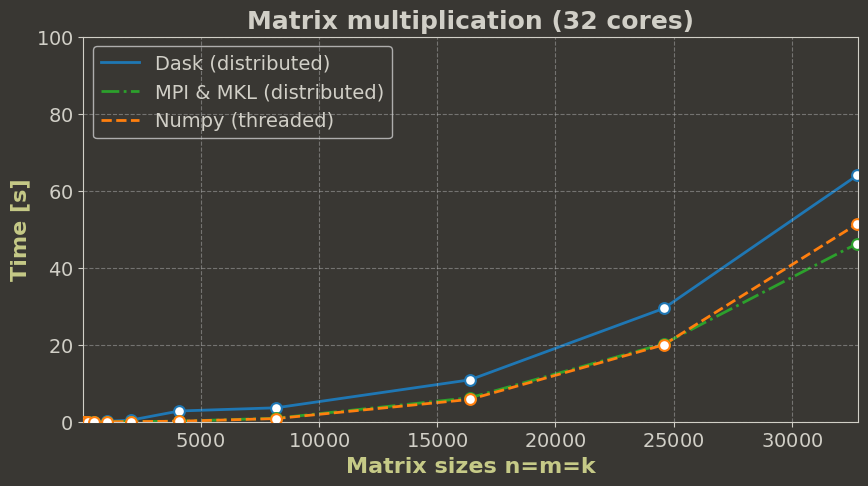

In [21]:
# Create plot
fig, ax = plt.subplots(1,1, figsize=(10,5))

cmap = plt.get_cmap("tab10")

# Set Some plot settings
labels = {"dask":"Dask (distributed)", "numpy":"Numpy (threaded)", "mkl":"MPI & MKL (distributed)"}
styles = {"dask":"-", "numpy":"--", "mkl":"-."}
colors = {"dask":cmap(0), "numpy":cmap(1), "mkl":cmap(2)}


for i, method in enumerate(data.index.get_level_values("method").unique()):
    cores = 32
    color = colors[method]
    label = labels[method]
    zoffset = 0


    if method == "numpy" and cores != 32:
        #Draw reference line
        cores = 32
        color = "gray"
        label = "Numpy (threaded 32 cores)"
        zoffset = -10



    # Select all with parallel 32
    data_32 = data.loc[:, cores, method]



    # Group by size
    ci50 = data_32.groupby("size").apply(lambda x: np.percentile(x, 50))
    ci25 = data_32.groupby("size").apply(lambda x: np.percentile(x, 2.5))
    ci75 = data_32.groupby("size").apply(lambda x: np.percentile(x, 97.5))

    # Print gflops
    gflops = ci50.index**2 / ci50 / 1e9

    # Plot
    x = ci50.index
    #ax.fill_between(x, ci25, ci75, alpha=0.3, color=color)
    ax.scatter(
        x,
        ci50,
        marker="o",
        c="white",
        s=60,
        edgecolors=color,
        linewidth=1.5,
        zorder=10 + zoffset,
    )


    # Plot with error bars
    #ax.errorbar(x, ci50, yerr=[ci50-ci25, ci75-ci50], color=color, label=labels[method], zorder=10 , linewidth=2, ls=styles[method])
    ax.plot(
        x, 
        ci50, 
        color=color, 
        label=label, 
        linewidth=2,
        ls=styles[method],
        zorder=zoffset,
    )

    # Plot dots 
    #ax.plot(x, ci50, "x", label=method)


ax.set_ylabel("Time [s]")

ax.set_xlabel("Matrix sizes n=m=k")

# Set formatter for x axis in power two steps ie. 2^8, 2^9, 2^10, ...
from matplotlib.ticker import MultipleLocator

# Remove scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Set lims
ax.set_xlim(32, 32768+32)



# Set power law axis
# Draw grid
ax.grid(True, which="both", ls="--", alpha=0.5)

# Set ticks at multiples of 2

# Disable scientific notation
ax.ticklabel_format(style='plain', axis='x')


ax.legend(loc="upper left")
ax.set_ylim(0, 100)

ax.set_title("Matrix multiplication (32 cores)")

# Save plot
save_kwargs = {"bbox_inches":"tight", "dpi":300, "transparent":True}
fig.savefig("../figures/matrix_multiplication_32_cores_1_node.png", **save_kwargs)

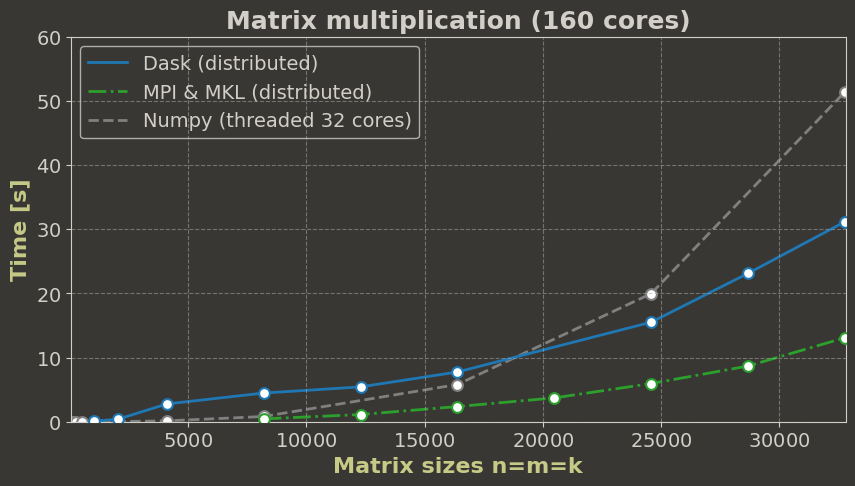

In [22]:
fig ,ax = plt.subplots(1,1, figsize=(10,5))


for i, method in enumerate(data.index.get_level_values("method").unique()):
    cores = 160
    color = colors[method]
    label = labels[method]
    zoffset = 0


    if method == "numpy" and cores != 32:
        #Draw reference line
        cores = 32
        color = "gray"
        label = "Numpy (threaded 32 cores)"
        zoffset = -10



    # Select all with parallel 32
    data_32 = data.loc[:, cores, method]



    # Group by size
    ci50 = data_32.groupby("size").apply(lambda x: np.percentile(x, 50))
    ci25 = data_32.groupby("size").apply(lambda x: np.percentile(x, 2.5))
    ci75 = data_32.groupby("size").apply(lambda x: np.percentile(x, 97.5))

    # Print gflops
    gflops = ci50.index**2 / ci50 / 1e9

    # Plot
    x = ci50.index
    #ax.fill_between(x, ci25, ci75, alpha=0.3, color=color)
    ax.scatter(
        x,
        ci50,
        marker="o",
        c="white",
        s=60,
        edgecolors=color,
        linewidth=1.5,
        zorder=10 + zoffset,
    )


    # Plot with error bars
    #ax.errorbar(x, ci50, yerr=[ci50-ci25, ci75-ci50], color=color, label=labels[method], zorder=10 , linewidth=2, ls=styles[method])
    ax.plot(
        x, 
        ci50, 
        color=color, 
        label=label, 
        linewidth=2,
        ls=styles[method],
        zorder=zoffset,
    )

    # Plot dots 
    #ax.plot(x, ci50, "x", label=method)


ax.set_ylabel("Time [s]")

ax.set_xlabel("Matrix sizes n=m=k")

# Set formatter for x axis in power two steps ie. 2^8, 2^9, 2^10, ...
from matplotlib.ticker import MultipleLocator

# Remove scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Set lims
ax.set_xlim(32, 32768+32)



# Set power law axis
# Draw grid
ax.grid(True, which="both", ls="--", alpha=0.5)

# Set ticks at multiples of 2

# Disable scientific notation
ax.ticklabel_format(style='plain', axis='x')


ax.legend(loc="upper left")
ax.set_ylim(0, 60)

ax.set_title("Matrix multiplication (160 cores)")

# Save plot
save_kwargs = {"bbox_inches":"tight", "dpi":300, "transparent":True}
fig.savefig("../figures/matrix_multiplication_160_cores_5_nodes.png", **save_kwargs)

## Calculate the GFLOPS for matrix multiplication depending on the core count i.e. scalability

In [23]:
data_scaling = pd.DataFrame(columns=["cores","time","method","size"])


for method in ["numpy", "dask", "mkl"]:
    for parallel in [32,64,96, 128, 160, 224,256]:
        if parallel != 32 and method == "numpy":
            continue


        df = data.loc[:, parallel, method].groupby("size").mean()
        df = df.reset_index()

        df["cores"] = parallel
        df["method"] = method
        data_scaling = pd.concat([data_scaling, df], ignore_index=True)





# Group by size
data_flops = data.loc[:, :,: ]
data_flops = data_flops.groupby(["method","size","parallel"]).apply(lambda x: np.percentile(x, 50))

# Get gflop/s
data_flops = data_flops.groupby(["method","size","parallel"]).apply(lambda x: np.percentile(x, 50))
size = data_flops.index.get_level_values("size")
gflop = (2.0*size**3)*1E-9;
gflops = gflop / data_flops

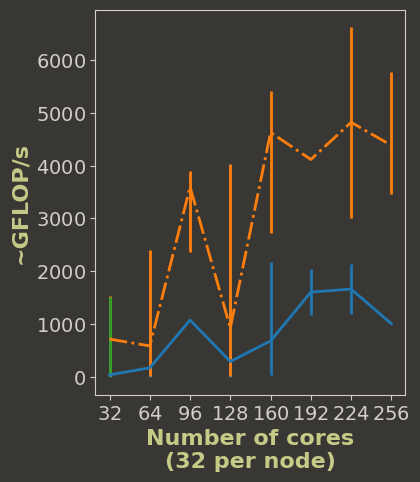

In [6]:
# Create plot
fig, ax = plt.subplots(1,1, figsize=(4,5))

for i, method in enumerate(data.index.get_level_values("method").unique()):

    color = cmap(i)

    # Get ci for each parallel
    ci = gflops.loc[method, :, :].groupby("parallel").quantile([0.05, 0.5, 0.95])

    
    y = ci.loc[:, 0.5]
    x = y.index
    
    # Plot with error bars
    ax.errorbar(x, y, yerr=[y-ci.loc[:, 0.05], ci.loc[:, 0.95]-y], color=color, label=labels[method], zorder=10 , linewidth=2, ls=styles[method])


ax.set_ylabel("~GFLOP/s")
# Disable scientific notation
ax.ticklabel_format(style='plain', axis='y')


ax.set_xlabel("Number of cores\n(32 per node)")
# Set formatter to multiple of 32
ax.xaxis.set_major_locator(MultipleLocator(32))



In [7]:

data_scaling["flop"] = data_scaling["size"]**3 * 2.0 * 1E-9
data_scaling["flops"] = data_scaling["flop"] / data_scaling["time"]
data_scaling.set_index(["cores","method"], inplace=True)
data_scaling = data_scaling[data_scaling["size"] == 16384]
data_scaling.drop(columns=["flop",'time','size'], inplace=True)
data_scaling["flops"] = data_scaling["flops"].astype(float)

In [8]:
data_scaling

flops
cores method             
32    numpy   1512.626449
      dask     806.866589
64    dask    1029.296840
96    dask    1085.963986
128   dask    1109.862589
160   dask    1088.928736
224   dask    1088.771098
256   dask    1004.729083
32    mkl     1391.453465
96    mkl     3036.767125
128   mkl     3744.756129
160   mkl     3549.978926
224   mkl     4193.238358
256   mkl     4768.914972

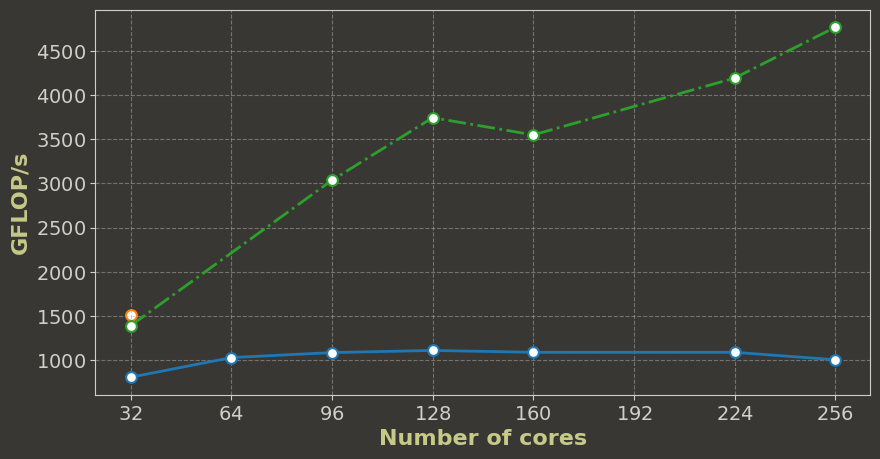

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,5),)


y = data_scaling.groupby(['method',"cores"]).quantile([0.05, 0.5, 0.95])

for method in ["dask", "mkl"]:

    temp = y.loc[method,:,0.05]

    lower = y.loc[method,:,0.05]
    upper = y.loc[method,:,0.95]
    lines = ax.vlines(
        x= temp.index,
        ymin=lower,
        ymax=upper,
        color=colors[method],
        ls="-",
        lw=6
    )
    lines.set_capstyle("round")

    ax.scatter(
        x=temp.index,
        y=y.loc[method,:,0.5], 
        marker="o",
        s=60,
        c="white",
        zorder=10,
        label=labels[method],
        edgecolor=colors[method],
        linewidth=1.5
    )

    ax.plot(
        temp.index,
        y.loc[method,:,0.5],
        color=colors[method],
        ls=styles[method],
        lw=2,
    )

# Plot numpz
ax.scatter(
    y.loc["numpy",:,0.5].index,
    y.loc["numpy",:,0.5],
    marker="o",
    c="white",
    s=60,
    edgecolors=colors["numpy"],
    label=labels["numpy"],
    linewidth=1.5,
)


ax.set_ylabel("GFLOP/s")

ax.set_xlabel("Number of cores")

#ax.set_yscale("log")

# Set grid
ax.grid(True, which="both", ls="--", alpha=0.5)


# Set x position of labels
ax.set_xticks([32, 64,  96, 128, 160, 192, 224, 256])

# Disable scientific notation
ax.ticklabel_format(style='plain', axis='x')
ax.ticklabel_format(style='plain', axis='y')





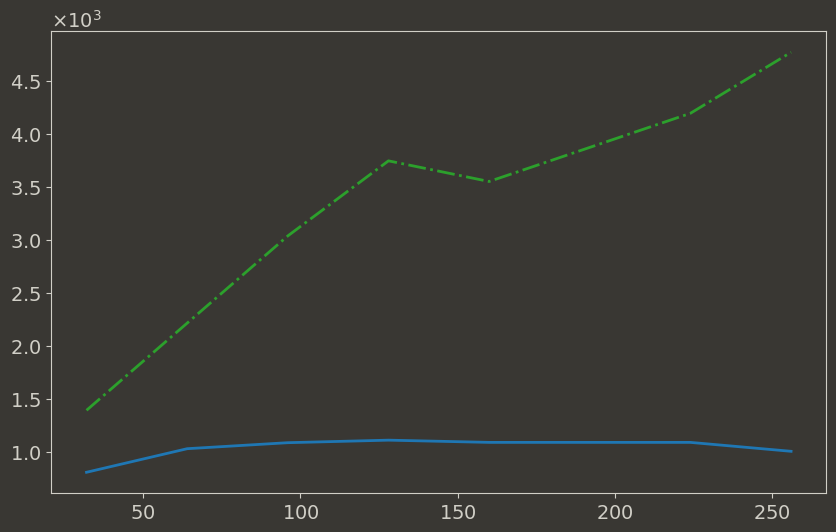

In [10]:
# Plot 64 cores
for method in ["numpy", "dask", "mkl"]:
    df = data_scaling.loc[:, method, :].groupby("cores")["flops"].mean()
    plt.plot(df.index, df, label=labels[method], ls=styles[method], color=colors[method])

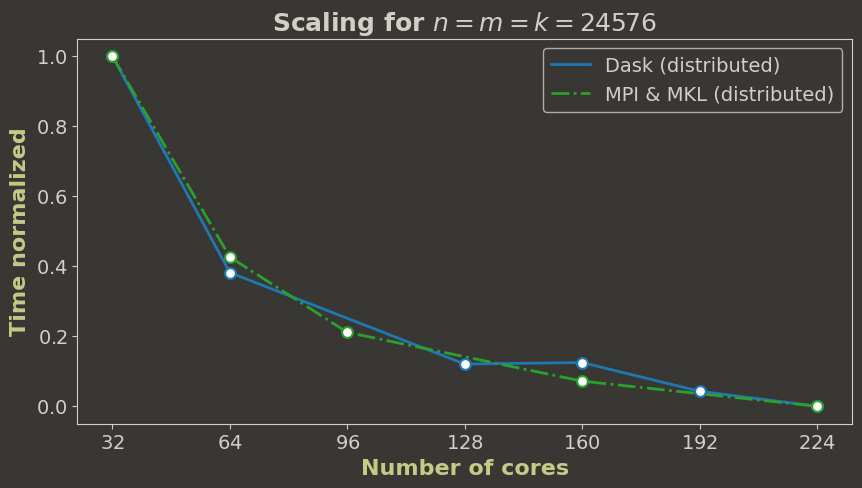

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,5))


scaling = data.loc[24576, :, :].groupby(["method","parallel"]).quantile([0.05, 0.5, 0.95])




for method in ["numpy", "dask", "mkl"]:
    cores = 160
    color = colors[method]
    label = labels[method]
    zoffset = 0


    if method == "numpy" and cores != 32:
        #Draw reference line
        cores = 32
        color = "orange"
        label = "Numpy (threaded)"
        zoffset = 10
        continue

        # Select all with parallel 32
    temp = scaling.loc[method, :, 0.5]

    # Normalize by between 0-1
    temp = (temp - temp.min() )/ (temp.max() - temp.min())



    # Plot
    x = temp.index
    #ax.fill_between(x, ci25, ci75, alpha=0.3, color=color)
    ax.scatter(
        x,
        temp,
        marker="o",
        c="white",
        s=60,
        edgecolors=color,
        linewidth=1.5,
        zorder=10 + zoffset,
    )


    # Plot with error bars
    #ax.errorbar(x, ci50, yerr=[ci50-ci25, ci75-ci50], color=color, label=labels[method], zorder=10 , linewidth=2, ls=styles[method])
    ax.plot(
        x, 
        temp, 
        color=color, 
        label=label, 
        linewidth=2,
        ls=styles[method],
        zorder=zoffset,
    )

    # Plot dots 
    

ax.set_xticks([32, 64,  96, 128, 160, 192, 224])

ax.set_ylabel("Time normalized")

ax.set_xlabel("Number of cores")



# Disable scientific notation for log scale
ax.ticklabel_format(style='plain', axis='y')
ax.ticklabel_format(style='plain', axis='x')

ax.legend(loc="upper right")

ax.title.set_text("Scaling for $n=m=k=24576$")


save_kwargs = {"bbox_inches":"tight", "dpi":300, "transparent":True}
fig.savefig("../figures/scaling_24576.png", **save_kwargs)